In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_curve, roc_auc_score

In [55]:
X_train = pd.read_csv('./../1.Data/TrainTest/X_train.csv')
X_test = pd.read_csv('./../1.Data/TrainTest/X_test.csv')
y_train = pd.read_csv('./../1.Data/TrainTest/y_train.csv')
y_test = pd.read_csv('./../1.Data/TrainTest/y_test.csv')
y_train = y_train['Target']
y_test = y_test['Target']

##### I. Baseline Dummy Classifier

In [56]:
#using dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=0) # stratified
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.6211453744493393

II. Logistic Regression

In [57]:
##Scale data and use logistic regression
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)


0.9129955947136564

In [58]:
y_pred = pipe.predict(X_test)
cnf= confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       564
           1       0.92      0.85      0.88       344

    accuracy                           0.91       908
   macro avg       0.91      0.90      0.91       908
weighted avg       0.91      0.91      0.91       908



In [59]:
print('Accuracy: ', acc)
print('Confusion Matrix: \n', cnf)

Accuracy:  0.9129955947136564
Confusion Matrix: 
 [[537  27]
 [ 52 292]]


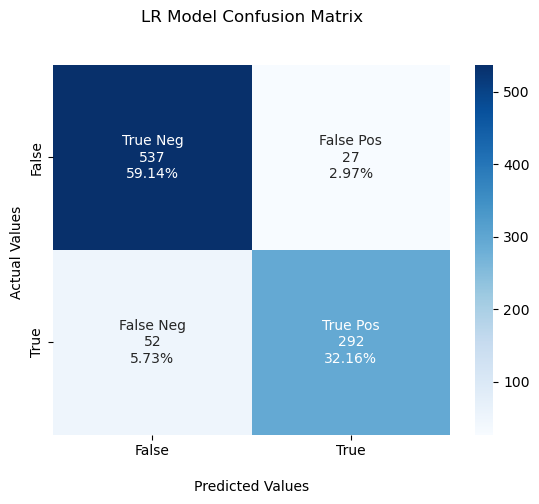

In [60]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cnf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cnf.flatten()/np.sum(cnf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues')

ax.set_title('LR Model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

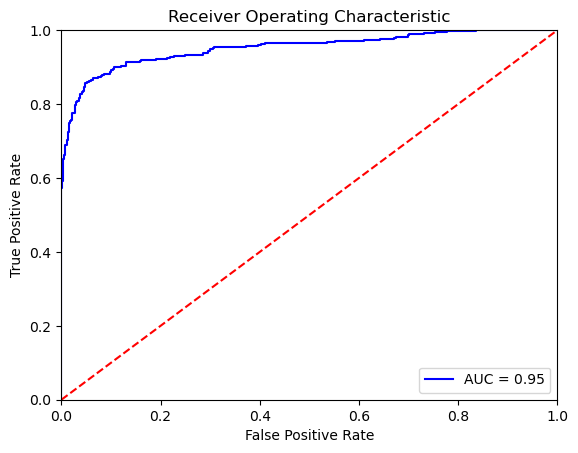

In [61]:

# calculate the fpr and tpr for all thresholds of the classification
probs = pipe.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Feature Importance and Odds Ratio:

**Feature Importance**
- Positive coefficient: As the feature value increases, the log odds of the target event increase, leading to a higher probability.
- Negative coefficient: As the feature value increases, the log odds of the target event decrease, leading to a lower probability.

**Odds Ratio** </br>
The odds ratio is the exponentiation of the coefficient.
- Odds ratio > 1: The odds of the event increase as the feature value increases.
- Odds ratio < 1: The odds of the event decrease as the feature value increases.
- Odds ratio = 1: The odds of the event are not affected by the feature.

Text(0, 0.5, 'Feature')

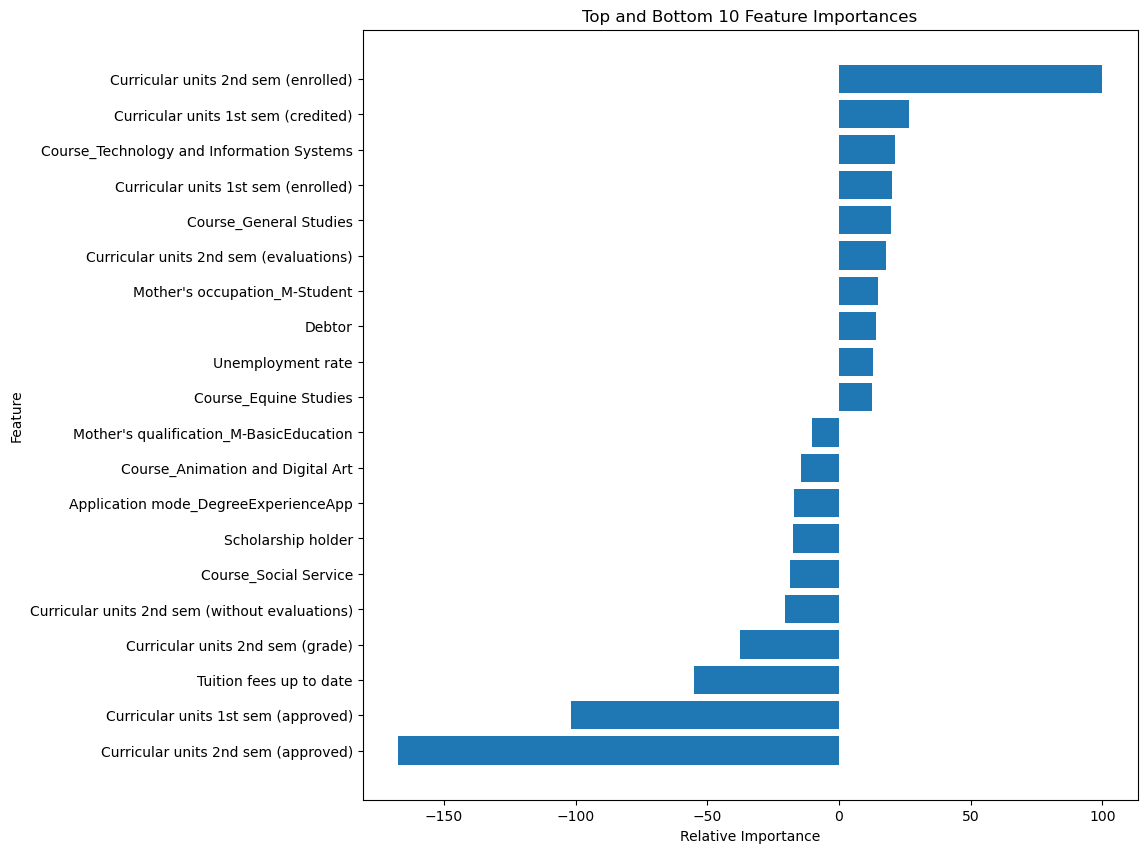

In [62]:
#Feature Importance
# Get the feature importance from the classifier
feature_importance = pipe.steps[1][1].coef_[0]

# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
# Get the top 10 and bottom 10 feature importances
top_10_feature_indexes = sorted_idx[-10:]
bottom_10_feature_indexes = sorted_idx[:10]

# Extract top and bottom features and importance values
top_10_features = np.array(X_train.columns)[top_10_feature_indexes]
top_10_importance = feature_importance[top_10_feature_indexes]
bottom_10_features = np.array(X_train.columns)[bottom_10_feature_indexes]
bottom_10_importance = feature_importance[bottom_10_feature_indexes]

#Add top 10 and bottom 10 to a dataframe
top_bottom_10_features = np.concatenate((top_10_features, bottom_10_features))
top_bottom_10_importance = np.concatenate((top_10_importance, bottom_10_importance))


# Plot the feature importances of LR Model
#sort the values in ascending order
top_bottom_10_importance, top_bottom_10_features = zip(*sorted(zip(top_bottom_10_importance, top_bottom_10_features)))
# Plot the feature importances of the forest
plt.figure(figsize=(10, 10))
plt.title("Top and Bottom 10 Feature Importances")
plt.barh(range(len(top_bottom_10_importance)), top_bottom_10_importance, align="center")
plt.yticks(range(len(top_bottom_10_importance)), top_bottom_10_features)
plt.xlabel("Relative Importance")
plt.ylabel("Feature")


#### Odds Ratio

In [63]:
#Odd Ratios
# Get Odds ratio

odd_ratio = np.exp(pipe.steps[1][1].coef_)
odd_ratio = pd.DataFrame(odd_ratio, columns=X_train.columns)
odd_ratio = odd_ratio.T
odd_ratio.columns = ['Odds Ratio']

In [64]:
odd_ratio.sort_values(by='Odds Ratio', ascending=False).head(10)

,Odds Ratio
Curricular units 2nd sem (enrolled),5.862364
Curricular units 1st sem (credited),1.601288
Course_Technology and Information Systems,1.453562
Curricular units 1st sem (enrolled),1.431009
Course_General Studies,1.419501
Curricular units 2nd sem (evaluations),1.367054
Mother's occupation_M-Student,1.297876
Debtor,1.285824
Unemployment rate,1.258804
Course_Equine Studies,1.245062


While the Odds Ratio tells you a 1 point increase in a given variable results in an increased chance of the dependent variable occuring, this isn't helpful when the features were scaled. In other words, it would be better to convert the data to an odds ratio that applies to each variable in their original scale. So, in the case of the above, a 1 point increase in curriculum units would either increase or decrease the likelihood of dropping out.

**Back Transformation for Odds Ratio in Original Scale**:
</br>
</br>

**Get the Coefficients:**
</br>
</br>
After fitting the model, obtain the coefficients (coef_) and intercept (intercept_) from the model.
</br>
</br>

**Back-Transformation:**
</br>
</br>
Use the inverse transform function of the scaler to transform the coefficients back to the original scale. The formula for back-transformation is as follows:
</br>
</br>
$$ Original Coefficient= Scaler Scale * Scaled Coefficient $$
​</br>
</br>
The scaler scale is the standard deviation of the original feature, for StandardScaler().
</br>
</br>
Calculate the Odds Ratio:
Once you have the coefficients in the original scale, calculate the odds ratio. The odds ratio for a one-unit increase in the original feature is given by:
</br>
</br>
$$ Odds Ratio = e^{Original Coefficient}\ $$


In [65]:
coef_scaled = pipe.steps[1][1].coef_ 
scaler = pipe.steps[0][1].scale_
original_coef = coef_scaled * scaler
odd_ratio = np.exp(original_coef)

In [66]:
odd_ratio = pd.DataFrame(odd_ratio, columns=X_train.columns)
odd_ratio = odd_ratio.T
odd_ratio.columns = ['Odds Ratio']

odd_ratio.sort_values(by='Odds Ratio', ascending=False).head(10)

,Odds Ratio
Curricular units 2nd sem (enrolled),53.871371
Age at enrollment,4.183663
Curricular units 2nd sem (evaluations),3.441704
Curricular units 1st sem (credited),3.155325
Curricular units 1st sem (enrolled),2.490333
Curricular units 1st sem (grade),2.064191
Unemployment rate,1.844124
Curricular units 2nd sem (credited),1.308692
Debtor,1.083381
Course_General Studies,1.069458


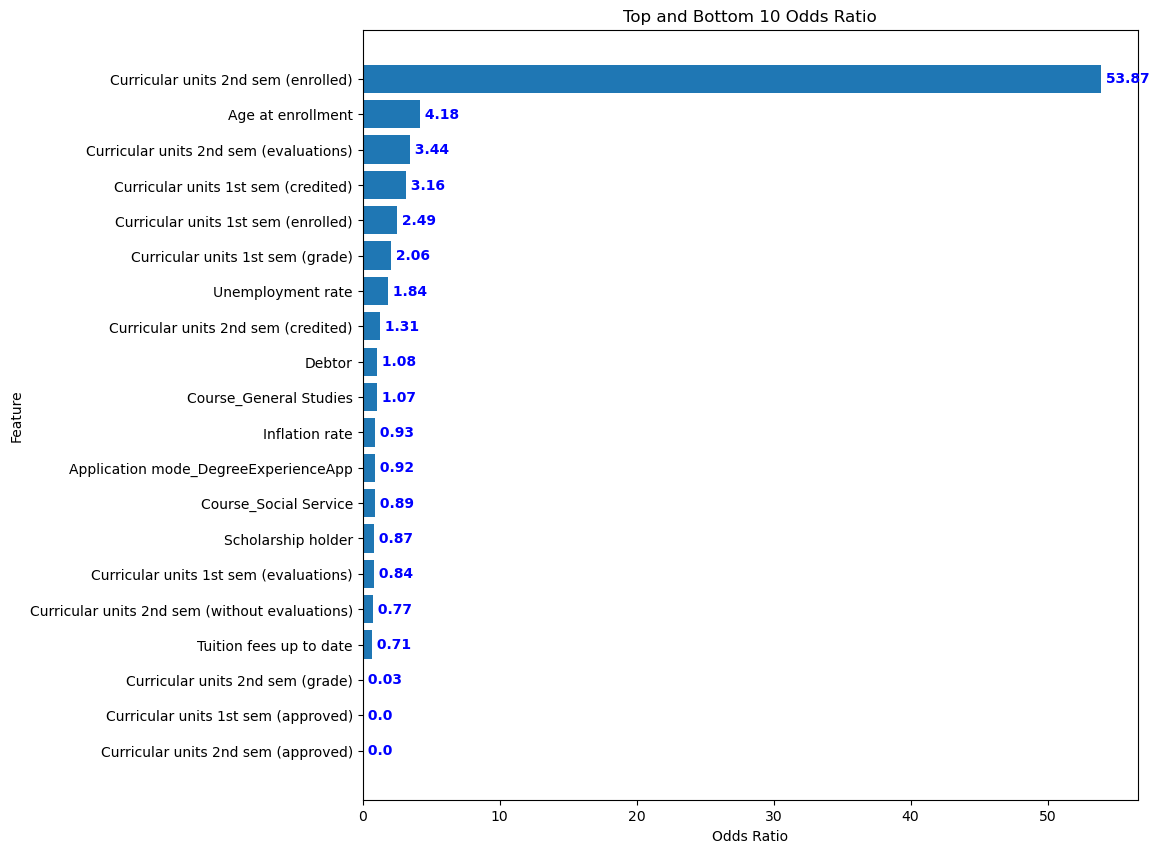

In [67]:
# Get the Top 10 Odds Ratios and the Bottom 10 (closest to 0)
top_10_features = odd_ratio.sort_values(by='Odds Ratio', ascending=False).head(10)
bottom_10_features = odd_ratio.sort_values(by='Odds Ratio', ascending=False).tail(10)
# Concatenate the top and bottom 10 features
top_bottom_10_features = pd.concat([top_10_features, bottom_10_features])
# Sort the values in ascending order
top_bottom_10_features = top_bottom_10_features.sort_values(by='Odds Ratio', ascending=True)
# Plot the top and bottom 10 features
plt.figure(figsize=(10, 10))
plt.title("Top and Bottom 10 Odds Ratio")
plt.barh(range(len(top_bottom_10_features)), top_bottom_10_features['Odds Ratio'], align="center")
plt.yticks(range(len(top_bottom_10_features)), top_bottom_10_features.index)
# add values in or on the bars
for i, v in enumerate(top_bottom_10_features['Odds Ratio']):
    plt.text(v, i, " "+str(round(v,2)), color='blue', va='center', fontweight='bold')


plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.show()


In [68]:
model_test_odds = top_bottom_10_features.index

#### Odds Ratio Summary:




## II. Review of Above Feature Importances: 

The model predicts heavily on Curricular Activity. If they aren't enrolled in 2nd semester courses, the outcome seems obvious, afterall. As a test, I would like to see if I can remove the curricular outcomes and look for opportunities for generalizbility. 

In [69]:
X_train_2 = pd.read_csv('./../1.Data/TrainTest/X_train_no2.csv')
X_test_2 = pd.read_csv('./../1.Data/TrainTest/X_test_no2.csv')
y_train_2 = pd.read_csv('./../1.Data/TrainTest/y_train_no2.csv')
y_test_2 = pd.read_csv('./../1.Data/TrainTest/y_test_no2.csv')
y_train_2 = y_train_2['Target']
y_test_2 = y_test_2['Target']


In [70]:
param_grid = {
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
    "logisticregression__penalty": ["l2"],
}

In [71]:
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", return_train_score=True)
grid_search.fit(X_train_2, y_train_2)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                         'logisticregression__penalty': ['l2']},
             return_train_score=True, scoring='roc_auc')

In [72]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_model)
print(best_params)
print(best_score)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01, random_state=42))])
{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
0.8464579325964265


In [73]:
best_model.fit(X_train_2, y_train_2)
y_pred_2 = best_model.predict(X_test_2)

In [74]:
cnf= confusion_matrix(y_test_2, y_pred_2)
acc = accuracy_score(y_test_2, y_pred_2)
print(classification_report(y_test_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       551
           1       0.79      0.61      0.69       357

    accuracy                           0.79       908
   macro avg       0.79      0.75      0.76       908
weighted avg       0.79      0.79      0.78       908



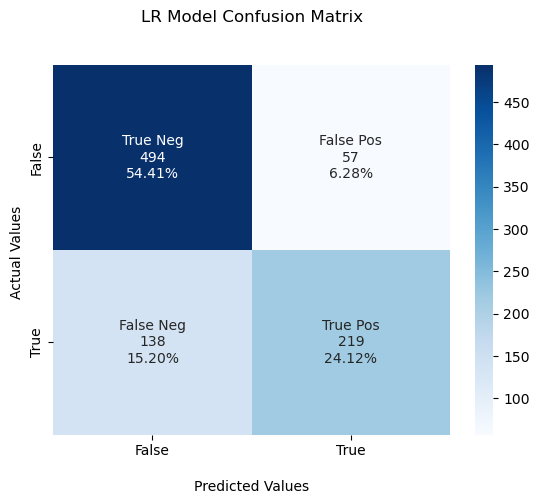

In [75]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cnf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cnf.flatten()/np.sum(cnf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues')

ax.set_title('LR Model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

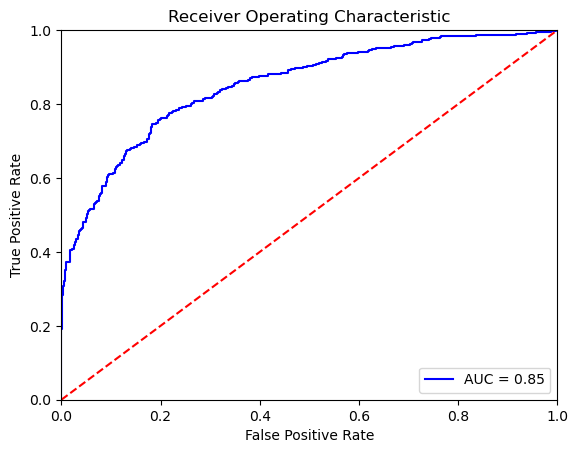

In [76]:
# calculate the fpr and tpr for all thresholds of the classification
probs = best_model.predict_proba(X_test_2)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_2, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0, 0.5, 'Feature')

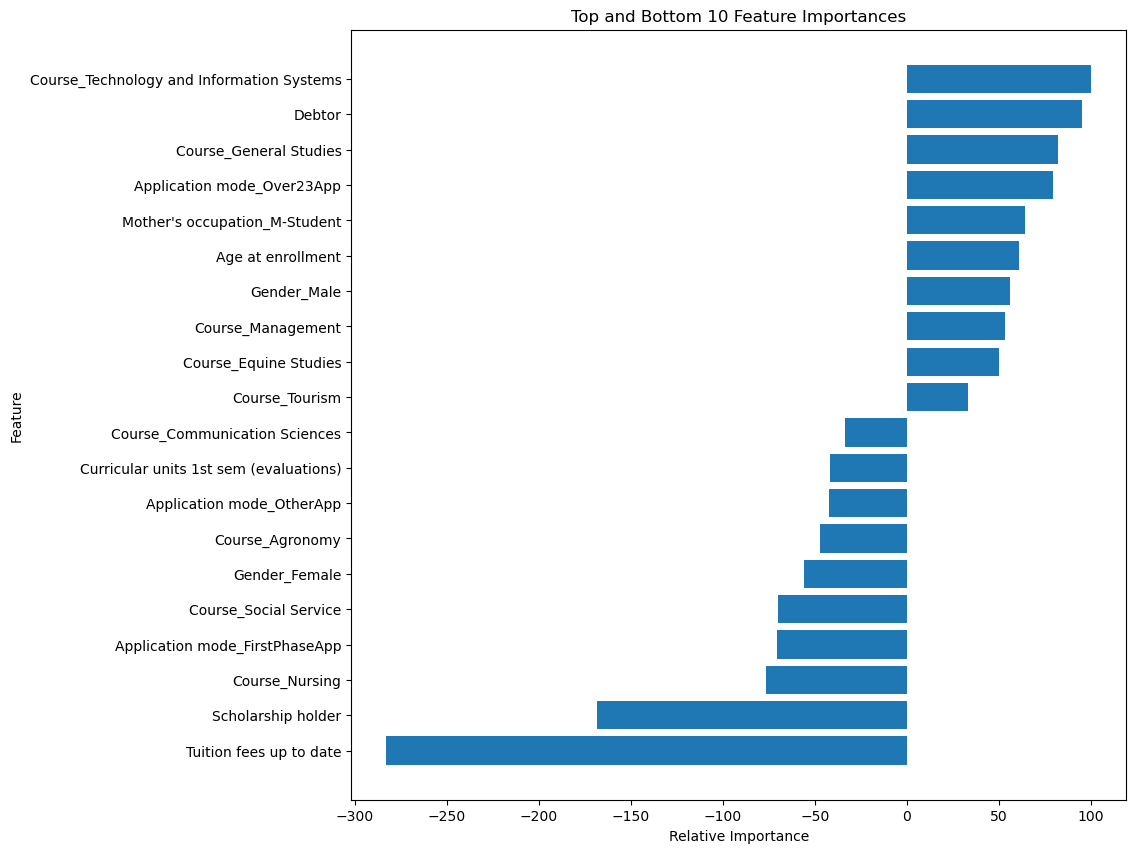

In [77]:
#Feature Importance
# Get the feature importance from the classifier
feature_importance = best_model.steps[1][1].coef_[0]

# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
# Get the top 10 and bottom 10 feature importances
top_10_feature_indexes = sorted_idx[-10:]
bottom_10_feature_indexes = sorted_idx[:10]

# Extract top and bottom features and importance values
top_10_features = np.array(X_train.columns)[top_10_feature_indexes]
top_10_importance = feature_importance[top_10_feature_indexes]
bottom_10_features = np.array(X_train.columns)[bottom_10_feature_indexes]
bottom_10_importance = feature_importance[bottom_10_feature_indexes]

#Add top 10 and bottom 10 to a dataframe
top_bottom_10_features = np.concatenate((top_10_features, bottom_10_features))
top_bottom_10_importance = np.concatenate((top_10_importance, bottom_10_importance))


# Plot the feature importances of LR Model
#sort the values in ascending order
top_bottom_10_importance, top_bottom_10_features = zip(*sorted(zip(top_bottom_10_importance, top_bottom_10_features)))
# Plot the feature importances of the forest
plt.figure(figsize=(10, 10))
plt.title("Top and Bottom 10 Feature Importances")
plt.barh(range(len(top_bottom_10_importance)), top_bottom_10_importance, align="center")
plt.yticks(range(len(top_bottom_10_importance)), top_bottom_10_features)
plt.xlabel("Relative Importance")
plt.ylabel("Feature")


In [78]:
#Odd Ratios
# Get Odds ratio

odd_ratio = np.exp(best_model.steps[1][1].coef_)
odd_ratio = pd.DataFrame(odd_ratio, columns=X_train_2.columns)
odd_ratio = odd_ratio.T
odd_ratio.columns = ['Odds Ratio']

In [79]:
coef_scaled = best_model.steps[1][1].coef_ 
scaler = best_model.steps[0][1].scale_
original_coef = coef_scaled * scaler
odd_ratio = np.exp(original_coef)

In [80]:
odd_ratio = pd.DataFrame(odd_ratio, columns=X_train_2.columns)
odd_ratio = odd_ratio.T
odd_ratio.columns = ['Odds Ratio']

odd_ratio.sort_values(by='Odds Ratio', ascending=False).head(10)

,Odds Ratio
Age at enrollment,3.569632
Unemployment rate,1.237296
Application mode_Over23App,1.083454
Debtor,1.080974
Gender_Male,1.071895
Course_Management,1.049501
Course_Technology and Information Systems,1.045746
Course_General Studies,1.044115
Mother's occupation_M-Student,1.033270
Application order,1.026264


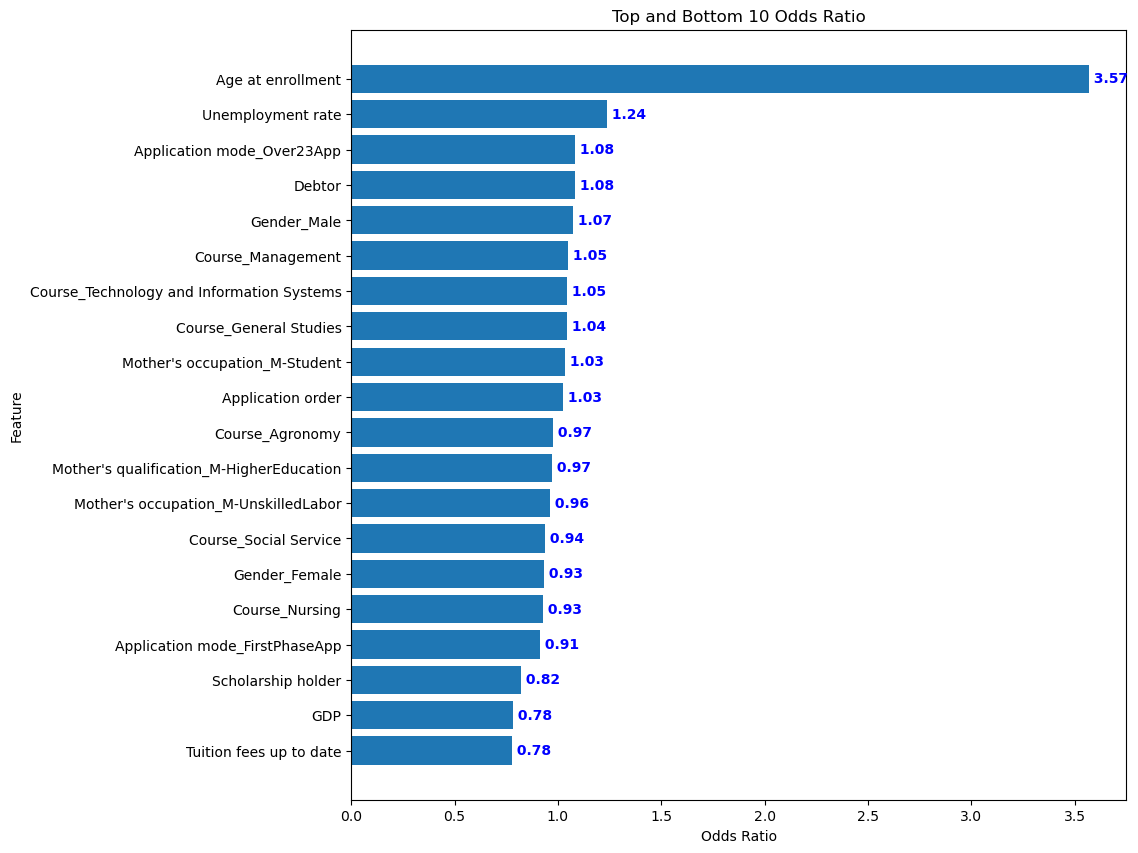

In [81]:
# Get the Top 10 Odds Ratios and the Bottom 10 (closest to 0)
top_10_features = odd_ratio.sort_values(by='Odds Ratio', ascending=False).head(10)
bottom_10_features = odd_ratio.sort_values(by='Odds Ratio', ascending=False).tail(10)
# Concatenate the top and bottom 10 features
top_bottom_10_features = pd.concat([top_10_features, bottom_10_features])
# Sort the values in ascending order
top_bottom_10_features = top_bottom_10_features.sort_values(by='Odds Ratio', ascending=True)
# Plot the top and bottom 10 features
plt.figure(figsize=(10, 10))
plt.title("Top and Bottom 10 Odds Ratio")
plt.barh(range(len(top_bottom_10_features)), top_bottom_10_features['Odds Ratio'], align="center")
plt.yticks(range(len(top_bottom_10_features)), top_bottom_10_features.index)
# add values in or on the bars
for i, v in enumerate(top_bottom_10_features['Odds Ratio']):
    plt.text(v, i, " "+str(round(v,2)), color='blue', va='center', fontweight='bold')


plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.show()

In [82]:
## TO DO: convert the below to a clean summary markdown cell

#accuracy is defined as the number of correct predictions divided by the total number of predictions
#precision is defined as the number of true positives divided by the number of true positives plus the number of false positives. 
#recall is defined as the number of true positives divided by the number of true positives plus the number of false negatives.
#F1 score is defined as the harmonic mean of precision and recall.
#ROC curve is a plot of the true positive rate against the false positive rate for the different possible cutpoints of a diagnostic test.
#AUC is the area under the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

#Accuracy is the probability that a sample is classified correctly.
#Precision, in other words, is the probability that a sample classified as positive is actually positive.
#Recall is the probability that a positive sample is classified as positive.
#F1 score is the harmonic mean of precision and recall.
#ROC, in otherwords, is the probability that a positive sample is classified as positive and a negative sample is classified as negative.


# Precision is the probability that a predicted positive is actually positive.
# Recall is the probability that an actual positive is predicted positive.

#For example, if a model predicts that 10 emails are spam, and 5 of those emails are actually spam, then the model's precision is 50%. 
#This means that the model is correct half of the time when it predicts that an email is spam.

#For example, if there are 100 spam emails in a dataset, and a model identifies 80 of them, then the model's recall is 80%. 
#This means that the model found 80% of the actual spam emails in the dataset.

#The F1 score is a good measure to use when the cost of false positives and false negatives is the same. 
#For example, the F1 score is often used to evaluate the performance of spam filters.


In [83]:
##Next Steps: Tree Based Models to compare performance
##Next Steps: Shapley Values to explain model predictions


The output model's feature importances and odds ratios heavily shift when 1 semester class data is removed. A better study would include a more robust student profile and course history. However, identifying features outside of grades creates potential for actionable insight. Courses with high drop out rates, early intervention for students with financial struggles, are all examples of actions to pursue as a result of the study.

##### Model Storage

In [84]:
pd.DataFrame(list(model_test_odds)).to_csv('./../1.Data/TrainTest/model_test_odds.csv', index=False)

In [85]:
with open("./../1.Data/Model/pipe.pkl", "wb") as f:
    pickle.dump(pipe, f)